In [1]:
# module load Bear-Python-DataScience/2019b-fosscuda-2019b-Python3.7.4
# module load sklearn-crfsuite/0.3.6-foss-2019b-Python3.7.47
# module load openpyxl...


# Load paths
data_tag = "England_Scotland_N.Ireland"
path_to_features = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/data/MumPredictPreprocessing/linked_data/diagnosis_{data_tag}.csv"  
# Save paths
path_to_model = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/CPRD_output/77conditions/" 
path_to_figs = path_to_model + 'plots/'
path_to_outputs = path_to_model + 'output/'

import os
os.chdir('/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from experiment import fit_restarts
from model.plotting import *
import helpers

torch.manual_seed(0)
np.random.seed(0)
%matplotlib inline

# import sys
# !{sys.executable} -m pip install --quiet --user scikit-learn==1.0.1


# Load CPRD data
Here we load the CPRD data from outside the repository. 
We then re-order the the columns (which won't affect modelling) to  aid visualisation later. 
Finally we remove non-multimorbidity cases (with fewer than 2 conditions)

In [2]:
df = pd.read_csv(path_to_features)
diag_frame = df[helpers.get_column_order_SAIL()]

# Remove some additional samples - these are patients with only one condition at the selected pregnancy. 
# This is done in addition to the pre-processing in R as we are taking a subset in this study.
df = df[diag_frame.sum(axis = 1) >= 2]
df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
df.index.name = "Sample index"
df.to_csv(path_to_outputs + F"MMsamples_{data_tag}.csv")                  # save the extra-filtered data along with identifiers

diag_frame = diag_frame[diag_frame.sum(axis = 1) >= 2]                                                    

# Tidy the condition names for plots later
diag_frame.columns = helpers.get_column_order_SAIL(plot=True)

N = diag_frame.shape[0]
D = diag_frame.shape[1]

# Check prevalence of diseases
print(f"{f'{D} conditions'.ljust(50)[:20]} | Count \n -------------------------------")
for i, j in zip(diag_frame.columns, diag_frame.to_numpy().sum(axis=0)):
    print(f"{i.ljust(50)[:20]} | {j}")
print(f"-------------------------------\n" + "Total".ljust(50)[:20] + f" | {N}")

77 conditions        | Count 
 -------------------------------
Cancer               | 2483
Asthma               | 72814
Allergic Rhin Conj   | 78945
Migraine             | 56238
Anxiety              | 81667
Depression           | 112863
Substance misuse     | 9865
Alcohol problem      | 4758
Eating disorder      | 10129
SMHmm                | 9596
Other mental         | 39754
Other headache       | 20270
AdrenalAll           | 56
Pituitary            | 1685
PCOS                 | 17251
Sarcoid              | 231
Leiomyoma            | 2889
Endometriosis        | 8792
Retinal detachment   | 403
PTH                  | 102
Heart failure        | 325
IHD/MI               | 578
Stroke               | 849
Interstitial lung    | 43
Blind                | 91
COPD                 | 271
Solid organ transpla | 157
Bronchiectasis       | 337
Neuro development    | 2192
Atopic eczema        | 13986
Cardiomyopathy       | 173
Cystic fybrosis      | 224
Sickle cell          | 113
Pulminary Heart     

# Run experiment

Plot order
* the prevalence of each condition in each quantised cluster
* the log odds ratio of each quantised cluster
* the cluster factor association matrix
* the prevalence within factors
* the log odds ratio within factors


In [3]:
latent_factors = 15
batch_size = 1024

architecture = {'enc_h': [D, D, D, latent_factors], 
                'dec_h': [latent_factors, D, D, D], 
                'constrain': ['L0', 'L0'],
               }
model_params = {'tmp_schedule': [4, 0.4, 0.4],
                 'epochs': 50,
                 'batch_size': batch_size,
                 'lr': 1e-3,
                 'verbose': 1,
                 'anneal': True,
                 'norm_beta': -0.4
                }


method_name = f'{data_tag}_Beta{model_params["norm_beta"]:.2f}_L{latent_factors}_batch{batch_size}'.replace(".", "_").replace("-", "Neg")

print(f"{method_name}\n===============")
restart_dicts, losses, labels, avg_ami = fit_restarts(diag_frame, architecture, model_params,
                                                      n_restarts=3,
                                                      save_path=f"{path_to_model}{method_name}",
                                                      force_retrain=False
                                                     )

# plot_restarts(diag_frame, best_dict, labels, plot_path=)

England_Scotland_N_Ireland_BetaNeg0_40_L15_batch1024
Loaded /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/CPRD_output/77conditions/England_Scotland_N_Ireland_BetaNeg0_40_L15_batch1024.pickle, seed 0
Loaded /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/CPRD_output/77conditions/England_Scotland_N_Ireland_BetaNeg0_40_L15_batch1024.pickle, seed 1
Loaded /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/CPRD_output/77conditions/England_Scotland_N_Ireland_BetaNeg0_40_L15_batch1024.pickle, seed 2
Averaged adjusted mutual information score over 3 combinations of seeds
 0.9429222709215228 +- 0.027728216509777408


## Check Adjusted Mutual Information and choose a seed. 

We perform multiple restarts to check the consistency of the clustering obtained under the chosen parameters (see ML4H paper).

Whilst we choose the lowest reconstruction loss, a smaller value doesn't necessarily imply better clustering.


In [4]:
best_dict = restart_dicts[np.argmin(losses)]

## Process the model output to find statistics of interest 
### - this also saves to .xls at the given path

In [5]:
output_dict = helpers.post_process(diag_frame, best_dict, save_path=path_to_outputs)

for k in output_dict.keys():
    print(k)

/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/helpers.py:292: RuntimeWarning: divide by zero encountered in true_divide
  RR_deviation[c_idx, :] = np.sqrt( 1/a - 1/(a+b) + 1/c - 1/(c+d) )
/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/helpers.py:296: RuntimeWarning: divide by zero encountered in true_divide
  OR[c_idx, :] = (a*d)/(b*c)
/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/helpers.py:297: RuntimeWarning: divide by zero encountered in true_divide
  OR_deviation[c_idx, :] = np.sqrt(1/a + 1/b + 1/c + 1/d)
/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/helpers.py:341: RuntimeWarning: divide by zero encountered in true_divide
  RR[factor, :] = (a/(a+b))/(c/(c+d))
/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/helpers.py:342: RuntimeWarning: divide by zero encountered in true_divide
  RR_deviation[factor, :] = np.sqrt( 1/a - 1/(a+b) + 1/c - 1/(c+d) )
/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/helpers.py:343: RuntimeWar

z_mean
z_binary
counts
unique_profiles
cluster_allocations
disentangled_y
lrs
val_loss
prevalence_clusters
RR_clusters
RR_deviation_clusters
OR_clusters
OR_deviation_clusters
cluster_factors
count_clusters
cluster_labels
prevalence_topics
RR_topics
RR_deviation_topics
OR_topics
OR_deviation_topics
count_topics
topic_labels


# Plot some of the post-processed outputs

## Clusters 

Not plotting any clusters containing less than 1% of the total samples

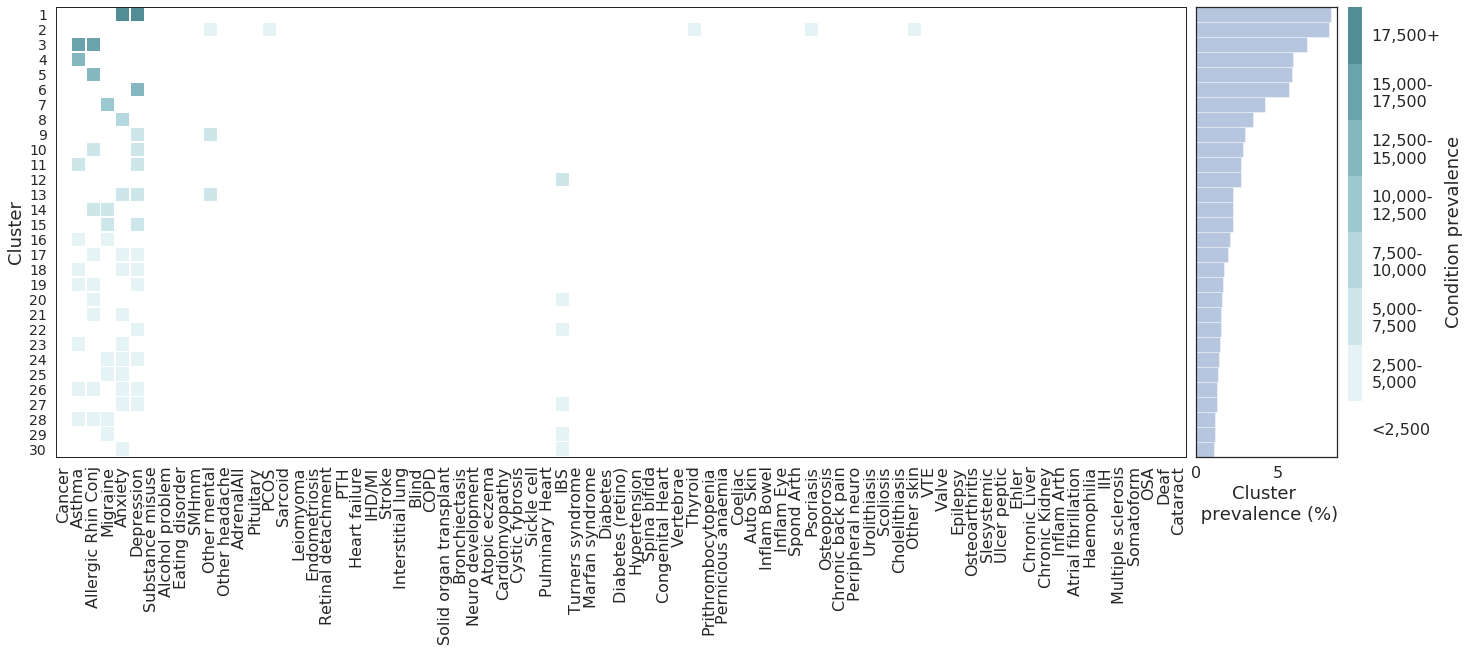

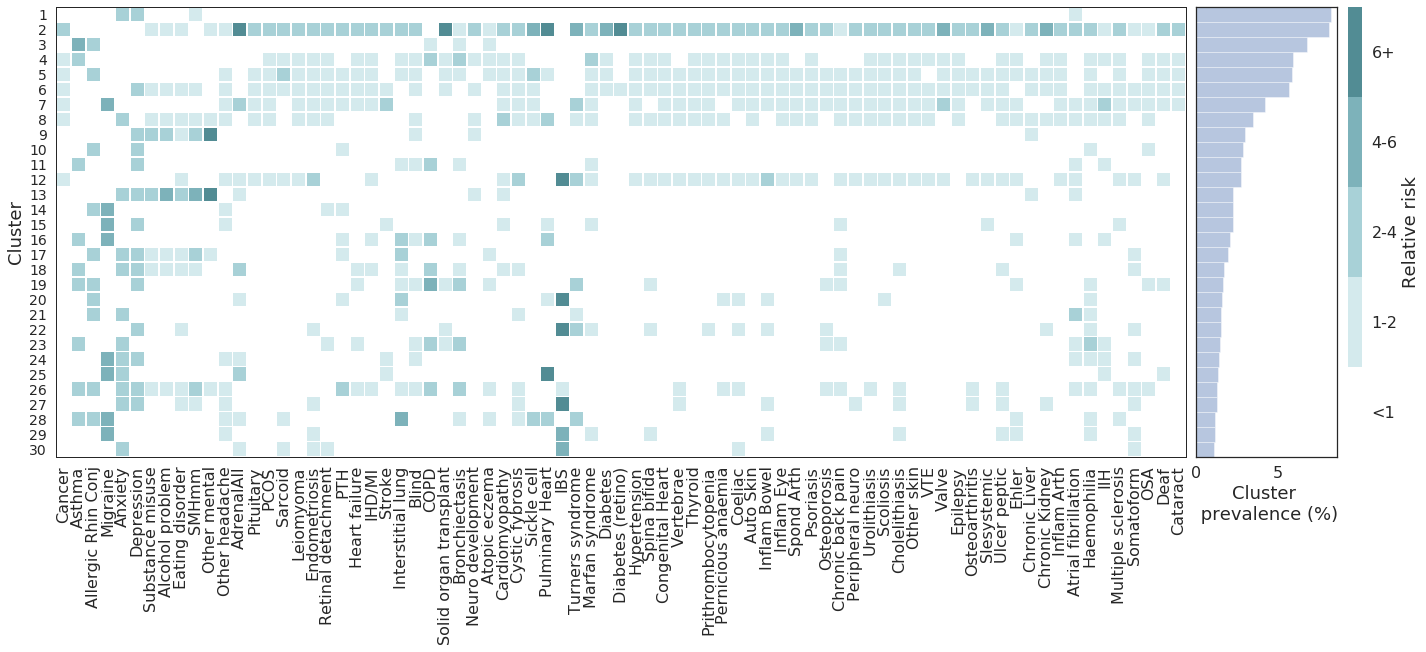

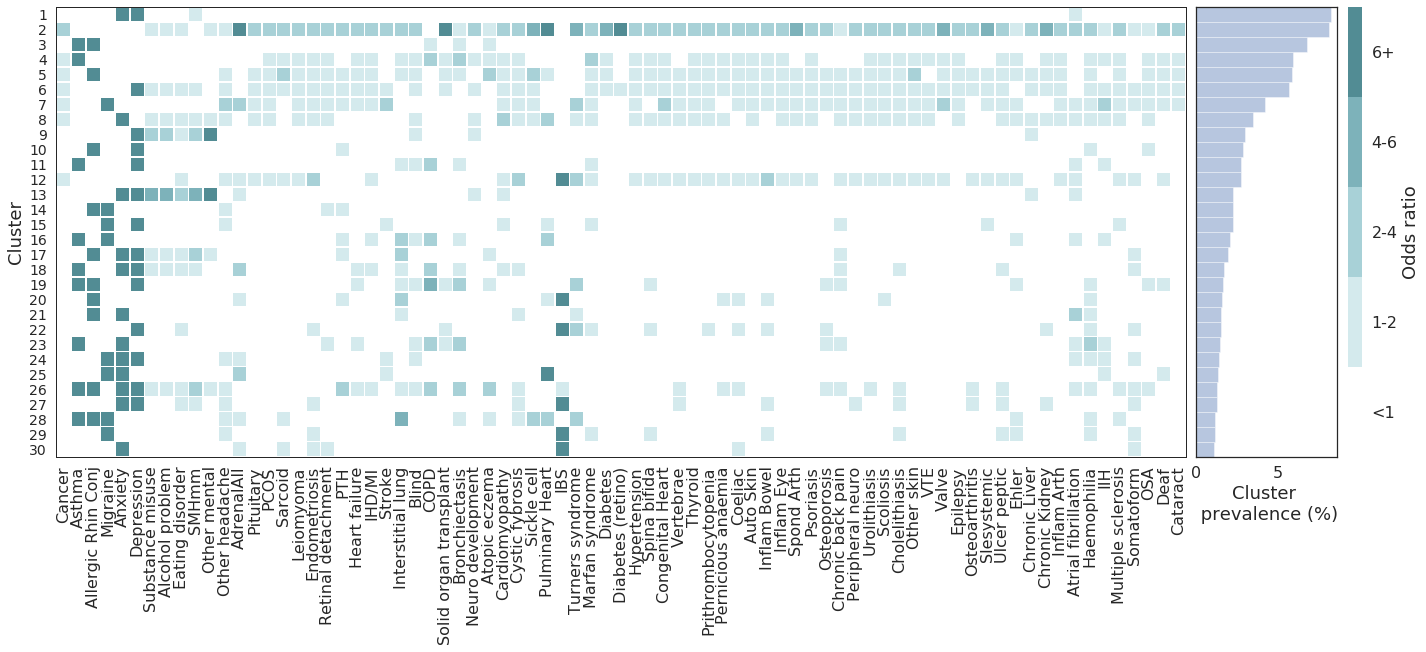

In [6]:
cluster_labels = output_dict['cluster_labels']     
cluster_prevalence = output_dict['prevalence_clusters']
cluster_RR = output_dict['RR_clusters']
cluster_OR = output_dict['OR_clusters']
cluster_counts = output_dict['count_clusters']


# Prevalence 
_increments = 2500
plot_grid(cluster_prevalence, cluster_names=cluster_labels, condition_names=diag_frame.columns.tolist(), counts=cluster_counts, perc_threshold=1,
          save_path=f'{path_to_figs}ClusterPrevalence',
          ylabel='Cluster',  cbar_label="Condition prevalence",
          bins = [int(_increments * i) for i in range(1, np.int(np.ceil(np.max(cluster_prevalence) / _increments)))]
          )


# Relative risk 
plot_grid(cluster_RR, cluster_names=cluster_labels, condition_names=diag_frame.columns.tolist(), counts=cluster_counts, perc_threshold=1,
          save_path=f'{path_to_figs}ClusterRelativeRisk',
          ylabel='Cluster',  cbar_label="Relative risk",
          bins = [1, 2, 4, 6]
          )  

# Odds ratio
plot_grid(cluster_OR, cluster_names=cluster_labels, condition_names=diag_frame.columns.tolist(), counts=cluster_counts, perc_threshold=1,
          save_path=f'{path_to_figs}ClusterOddsRatio',
          ylabel='Cluster',  cbar_label="Odds ratio",
          bins = [1, 2, 4, 6]
          )  


## Latent factors

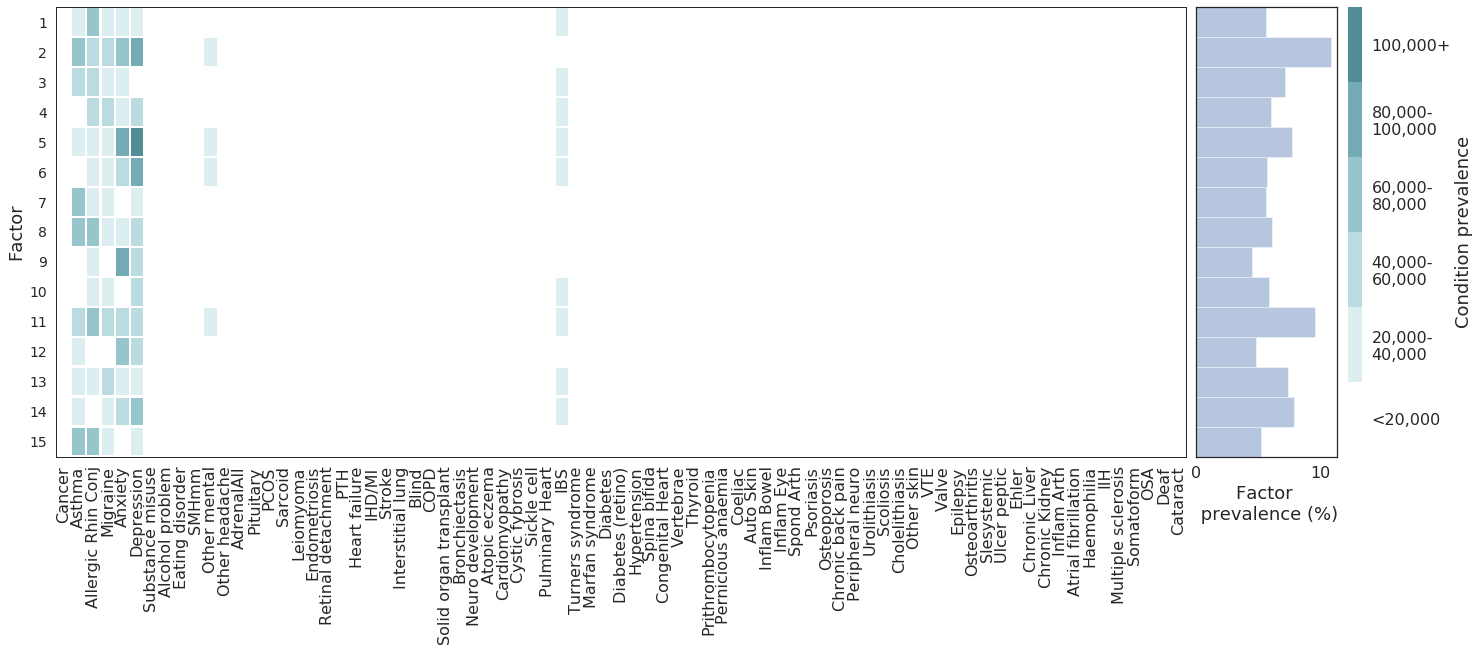

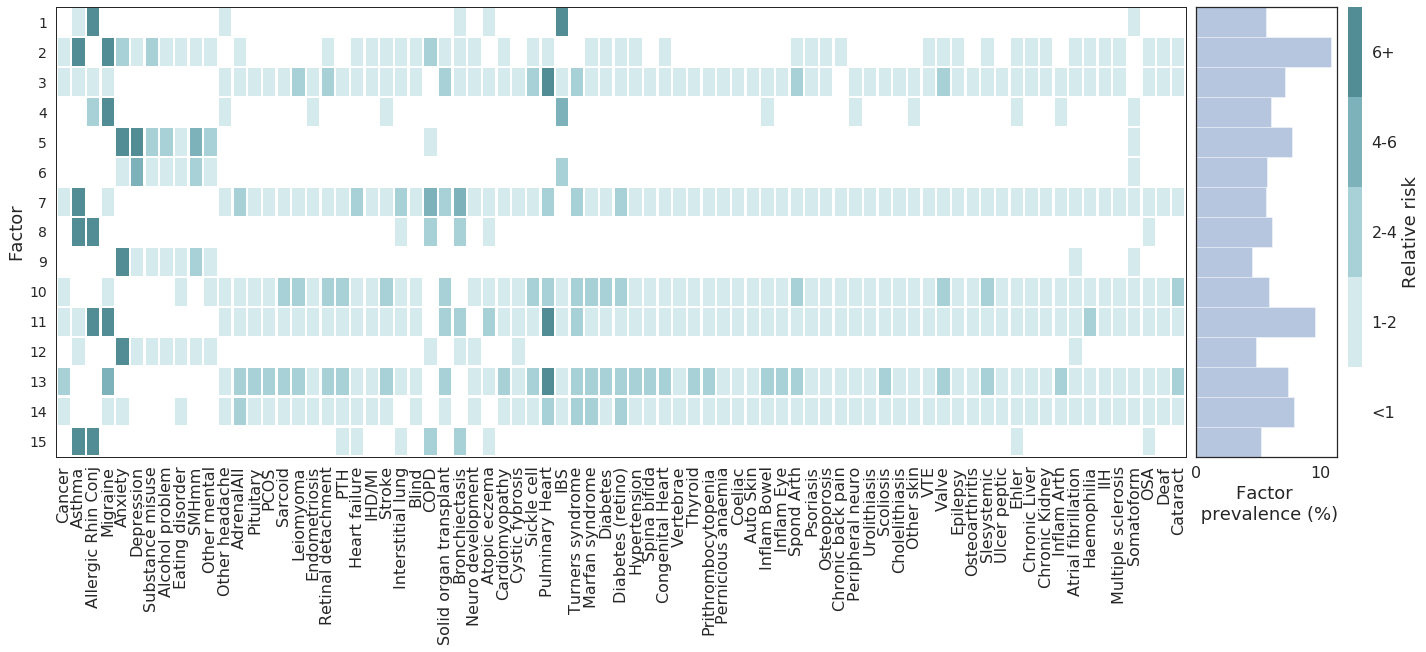

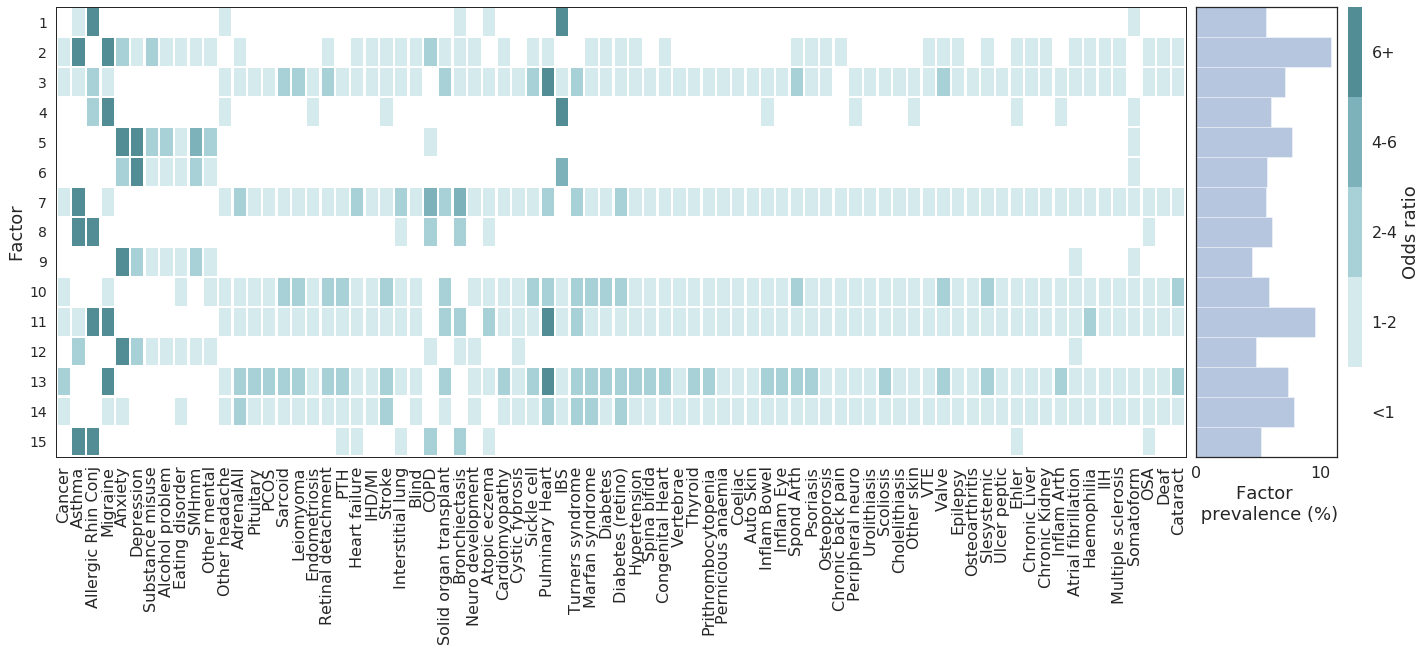

In [7]:
factor_labels = output_dict['topic_labels']     
factor_prevalence = output_dict['prevalence_topics']
factor_RR = output_dict['RR_topics']
factor_OR = output_dict['OR_topics']
factor_counts = output_dict['count_topics']

# Prevalence 
_increments = 20000
plot_grid(factor_prevalence, cluster_names=factor_labels, condition_names=diag_frame.columns.tolist(), counts=factor_counts, perc_threshold=None,
          save_path=f'{path_to_figs}FactorPrevalence',
          ylabel='Factor',  cbar_label="Condition prevalence",
          bins = [int(_increments * i) for i in range(1, np.int(np.ceil(np.max(factor_prevalence) / _increments)))]
          )


# Relative risk 
plot_grid(factor_RR, cluster_names=factor_labels, condition_names=diag_frame.columns.tolist(), counts=factor_counts, perc_threshold=None,
          save_path=f'{path_to_figs}FactorRelativeRisk',
          ylabel='Factor',  cbar_label="Relative risk",
          bins = [1, 2, 4, 6]
          )  

# Odds ratio
plot_grid(factor_OR, cluster_names=factor_labels, condition_names=diag_frame.columns.tolist(), counts=factor_counts, perc_threshold=None,
          save_path=f'{path_to_figs}FactorOddsRatio',
          ylabel='Factor',  cbar_label="Odds ratio",
          bins = [1, 2, 4, 6]
          )  

## And look at the relationship between clusters and factors

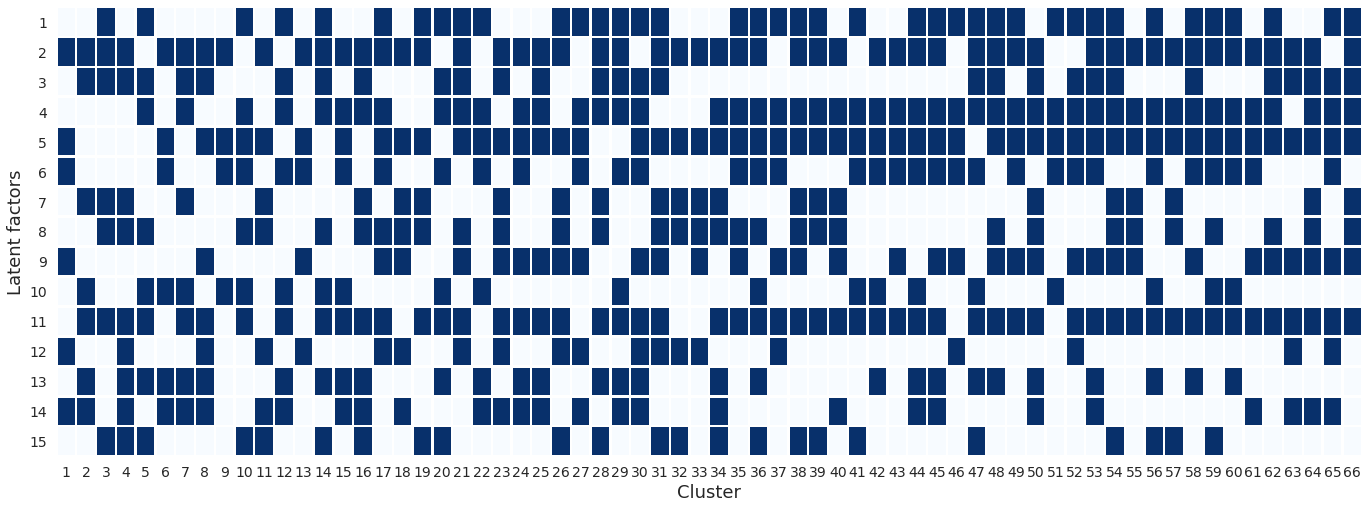

In [8]:
association_matrix = output_dict['cluster_factors'].T

#  Cluster-factor association matrix
cluster_factor_association(association_matrix,
                           xlabel='Cluster', ylabel='Latent factors',
                           x_ticks=cluster_labels, y_ticks=factor_labels, 
                           figsize=[3, 1.5], save_path=f'{path_to_figs}Cluster_factor_association')